<a href="https://colab.research.google.com/github/mkpvasu/Brain-Tumor-Classification/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><center>DATASET PREPARATION</center></b>

The [dataset](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427) used for our brain tumor classification model is published by Jun Chen.

More information about the dataset:
<p align = 'justify'>It contains 3064 T1-weighted contrast-inhanced MRI images of patients with three kinds of brain tumor: meningioma (708 slices),  glioma (1426 slices), and pituitary tumor (930 slices).</p>

---
This data is organized in matlab data format (.mat file). Each file stores a struct containing the following fields for an image:

<b>cjdata.label</b> : 1 for meningioma, 2 for glioma, 3 for pituitary tumor 

* <b>cjdata.PID</b> : patient ID
* <b>cjdata.image</b> : image data
* <b>cjdata.tumorBorder</b> : a vector storing the coordinates of discrete points on tumor border
* <b>cjdata.tumorMask</b> : a binary image with 1s indicating tumor region

In [ ]:
!git clone https://github.com/tzuan16/BrainTumorClassification

Cloning into 'BrainTumorClassification'...
remote: Enumerating objects: 3575, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 3575 (delta 38), reused 30 (delta 10), pack-reused 3488
Receiving objects: 100% (3575/3575), 847.52 MiB | 24.66 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Checking out files: 100% (3574/3574), done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import time
from sklearn.metrics import confusion_matrix, classification_report
import h5py
from PIL import Image

In [ ]:
import numpy as np

import os

def categorize_data():
  dir = 'BrainTumorClassification/data/'
  meningioma = []
  glioma = []
  pituitary = []

  for filename in os.listdir(dir):
    f = h5py.File(dir + filename,'r')
    data = f['cjdata']
    label = data['label'][0,0]
    image = np.array(data['image'])

    if np.size(image) != 262144:
      continue

    try:
      if label == 1:
        meningioma.append([image, label])
      elif label == 2:
        glioma.append([image, label])
      elif label == 3:
        pituitary.append([image, label])
    except:
      continue

  print('Data categorized')
  return meningioma,glioma,pituitary

In [ ]:
meningioma,glioma,pituitary = categorize_data()

Data categorized


In [ ]:
import matplotlib.pyplot as plt

def imshow(npimg):
    plt.imshow(npimg)
    plt.show()

print(np.shape(pituitary[0][0]))

(512, 512)


In [ ]:
import random

# Define the dataset to be used for training as train_data and test as test_data

train_data = []
val_data = []
test_data = []
img = None
label = None

# Define the ratio of train, validation and test data split for each category of tumors.
# Suppose if the train_ratio is 0.7, then 70% of images in each category will be added to the training data with shuffling within particular category each time.
# Suppose if the val_ratio is 0.15, then 15% of images in each category will be added to the validation data with shuffling within particular category each time.

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Splitting the meningioma according to the train_test_ratio and adding them to training data

meningioma_train_split = round(train_ratio*len(meningioma))
meningioma_val_split = round(val_ratio*len(meningioma))
meningioma_test_split = round(test_ratio*len(meningioma))

random.shuffle(meningioma)
train_data += meningioma[:meningioma_train_split][:]
val_data += meningioma[meningioma_train_split:meningioma_train_split+meningioma_val_split][:]
test_data += meningioma[meningioma_train_split+meningioma_val_split:][:]

# Splitting the glioma according to the train_test_ratio and adding them to training data

glioma_train_split = round(train_ratio*len(glioma))
glioma_val_split = round(val_ratio*len(glioma))
glioma_test_split = round(test_ratio*len(glioma))

random.shuffle(glioma)
train_data += glioma[:glioma_train_split][:]
val_data += glioma[glioma_train_split:glioma_train_split+glioma_val_split][:]
test_data += glioma[glioma_train_split+glioma_val_split:][:]

# Splitting the pituitary according to the train_test_ratio and adding them to training data

pituitary_train_split = round(train_ratio*len(pituitary))
pituitary_val_split = round(val_ratio*len(pituitary))
pituitary_test_split = round(test_ratio*len(pituitary))

random.shuffle(pituitary)
train_data += pituitary[:pituitary_train_split][:]
val_data += pituitary[pituitary_train_split:pituitary_train_split+pituitary_val_split][:]
test_data += (pituitary[pituitary_train_split+pituitary_val_split:][:])

# Shuffle data to make our model more robust as it encounters variations each time we run the model
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# Resize img
tmp = []
for img,label in train_data:
  rimg = cv2.resize(img,(64,64))
  tmp.append([rimg, label])
train_data = [i for i in tmp]
tmp.clear();

for img,label in test_data:
  rimg = cv2.resize(img,(64,64))
  tmp.append([rimg, label])
test_data = [i for i in tmp];

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of testing samples: {len(test_data)}")

Number of training samples: 2134
Number of validation samples: 457
Number of testing samples: 458


In [ ]:
class BrainTumorDataset(Dataset):
  def __init__(self, images, labels):
    # images
    self.X = images
    # labels
    self.y = labels
    
    # Transformation for converting original image array to an image and then convert it to a tensor
    self.tf = transforms.Compose([transforms.ToPILImage(), transforms.Resize([64,64],transforms.InterpolationMode.NEAREST), transforms.ToTensor()])
    
    # Transformation for converting original image array to an image and then convert it to a tensor
    self.transform = transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor()
    ])

    # Transformation for converting original image array to an image, rotate it randomly between -45 degrees and 45 degrees, and then convert it to a tensor
    #self.transform1 = transforms.Compose([
    #    transforms.ToPILImage(),                                          
    #    transforms.RandomRotation(45),
    #    transforms.ToTensor()                                 
    #])

    # Transformation for converting original image array to an image, vertically flipping it with a probability of 0.75 and then convert it to a tensor
    #self.transform1 = transforms.Compose([
    #    transforms.ToPILImage(),                                          
    #    transforms.RandomVerticalFlip(p=0.75),
    #    transforms.ToTensor()                                 
    #])

  def __len__(self):
    # return length of image samples
    return len(self.X)

  def __getitem__(self, idx):
    # perform transformations on one instance of X
    # Original image as a tensor
    data = self.transform(self.X[idx])

    # Augmented image at 45 degrees as a tensor
    #aug45 = self.transform1(self.X[idx])

    # Augmented image with vertical flip as a tensor
    #augvp = self.transform1(self.X[idx])     
    
    # store the transformed images in a list
    new_batch = [data]

    # one-hot encode the labels
    labels = torch.zeros(4, dtype=torch.float32)
    labels[int(self.y[idx])] = 1.0

    new_labels = [labels]

    # 2 augmented images and corresponding labels per sample will be returned
    return (torch.stack(new_batch),torch.tensor(self.y[idx]))

In [ ]:
train_set = BrainTumorDataset([x[0] for x in train_data], [x[1] for x in train_data])
val_set = BrainTumorDataset([x[0] for x in val_data], [x[1] for x in val_data])
test_set = BrainTumorDataset([x[0] for x in test_data], [x[1] for x in test_data])

In [ ]:
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

In [ ]:
def get_data(trainset, valset, testset):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

  return {'train': trainloader, 'val': valloader, 'test': testloader}

data = get_data(train_set, val_set, test_set)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def train(net, dataloader, epochs=32, lr=0.01, momentum=0.1, decay=0.01, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, (inputs,labels) in enumerate(data['train']):

        # set label as cuda if device is cuda
        inputs, labels = inputs.type(torch.cuda.FloatTensor).to(device), labels.type(torch.cuda.LongTensor).to(device)
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.view(-1, 1, 64, 64).repeat(1, 3, 1, 1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0], batch[1]
          images, labels = images.type(torch.cuda.FloatTensor).to(device), labels.type(torch.cuda.LongTensor).to(device)
          images = images.view(-1, 1, 64, 64).repeat(1, 3, 1, 1)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[1,   100] loss: 1.969
[1,   200] loss: 1.133
[1,   300] loss: 0.996
[1,   400] loss: 0.741
[1,   500] loss: 0.657
[2,   100] loss: 0.606
[2,   200] loss: 0.535
[2,   300] loss: 0.581
[2,   400] loss: 0.458
[2,   500] loss: 0.449
[3,   100] loss: 0.366
[3,   200] loss: 0.453
[3,   300] loss: 0.401
[3,   400] loss: 0.304
[3,   500] loss: 0.277
[4,   100] loss: 0.227
[4,   200] loss: 0.232
[4,   300] loss: 0.318
[4,   400] loss: 0.280
[4,   500] loss: 0.284
[5,   100] loss: 0.264
[5,   200] loss: 0.150
[5,   300] loss: 0.274
[5,   400] loss: 0.169
[5,   500] loss: 0.139
[6,   100] loss: 0.136
[6,   200] loss: 0.110
[6,   300] loss: 0.143
[6,   400] loss: 0.211
[6,   500] loss: 0.177
[7,   100] loss: 0.078
[7,   200] loss: 0.093
[7,   300] loss: 0.095
[7,   400] loss: 0.217
[7,   500] loss: 0.154
[8,   100] loss: 0.170
[8,   200] loss: 0.123
[8,   300] loss: 0.152
[8,   400] loss: 0.084
[8,   500] loss: 0.120
[9,   100] loss: 0.112
[9,   200] loss: 0.077
[9,   300] loss: 0.123
[9,   400] 

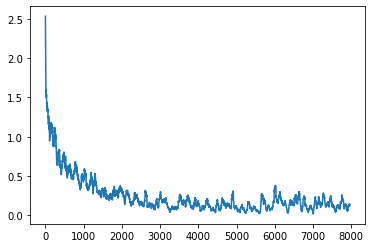

In [ ]:
import torchvision

net = torchvision.models.resnet50(pretrained = True)
for param in net.parameters():
    param.requires_grad = True

conv_losses = train(net, data['train'], epochs=15, lr=.01)
plt.plot(smooth(conv_losses, 50))

print("Training accuracy: %f" % accuracy(net, data['train']))
print("Testing  accuracy: %f" % accuracy(net, data['test']))